# Anime Classifier with Naïve Bayes
## Goal
Classify animes using their synopses into genres.
## Process
* Fetch anime data using an API
* Parse this data into class instances to facilitate processing
* Create a dataframe using our data, adding, for each word of the vocabulary, its number of occurences in each synopsis
* Implement the Multinomial Naïve Bayes algorithm -> calculate constants + classify
* Compute success rate for each genre
* Improve the classification system to improve the success rate

## Fetching Anime Data using an API
The API we will use is [Jikan](https://jikan.docs.apiary.io/), an unofficial API for the website [MyAnimeList](https://myanimelist.net/).
It does no require any authentication.

The only type of request we will use fetches the most popular animes of a specific genre, divided by pages of 99 animes ([doc](https://jikan.docs.apiary.io/#reference/0/genre)).


In [245]:
import requests
import json
import pandas as pd
import time
import re
import os.path
from os import path
# makes it so that Jupyter displays the return values, even when they are not at the very end of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

class Constants:
    FORCE_API_GET = False
    FORCE_COMPUTE_PARAMETERS = False
#     ANIMES_CSV_FILENAME = "animes_from_api.csv"
    ANIMES_CSV_FILENAME = "animes_from_api_more.csv"
    PARAMETERS_FILENAME = "parameters_all_genres_one_page.json"
    PARAMETERS_NO_FILENAME = "parameters_no_all_genres_one_page.json"

In [15]:
# gets the first page of the most popular animes of genre of id 8 (Drama).
# then converts it to a python dictionary
requests.get("https://api.jikan.moe/v3/genre/anime/8/1").json()

{'request_hash': 'request:genre:903a543f9a6ca027a1ea4eb619791bb1776ca2cf',
 'request_cached': True,
 'request_cache_expiry': 20845,
 'mal_url': {'mal_id': 8,
  'type': 'anime',
  'name': 'Drama Anime',
  'url': 'https://myanimelist.net/anime/genre/8/Drama'},
 'item_count': 2499,
 'anime': [{'mal_id': 16498,
   'url': 'https://myanimelist.net/anime/16498/Shingeki_no_Kyojin',
   'title': 'Shingeki no Kyojin',
   'image_url': 'https://cdn.myanimelist.net/images/anime/10/47347.jpg',
   'synopsis': "Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is s

In [2]:
#get one anime of id 1
response = requests.get("https://api.jikan.moe/v3/anime/1").json()
#get the anime of anime of id 1 page 1 (99 animes?)
"https://api.jikan.moe/v3/genre/anime/1/1"

'https://api.jikan.moe/v3/genre/anime/1/1'

In [190]:
genres_name = {
    4: "Comedy",
    8: "Drama"
}
# genres gathered by requesting 500+ animes
# genres = ['Romance',
#  'Historical',
#  'Space',
#  'Cars',
#  'Game',
#  'Supernatural',
#  'Fantasy',
#  'Psychological',
#  'Sci-Fi',
#  'Seinen',
#  'Parody',
#  'Drama',
#  'Action',
#  'Josei',
#  'Police',
#  'Super Power',
#  'Sports',
#  'Military',
#  'Demons',
#  'Vampire',
#  'Adventure',
#  'Shoujo Ai',
#  'Mecha',
#  'Shounen',
#  'Horror',
#  'Kids',
#  'Dementia',
#  'Samurai',
#  'Shounen Ai',
#  'Slice of Life',
#  'Comedy',
#  'Magic',
#  'Shoujo',
#  'Mystery',
#  'Music',
#  'Thriller',
#  'Martial Arts',
#  'School',
#  'Harem',
#  'Ecchi']
genres = {'Action',
 'Adventure',
 'Cars',
 'Comedy',
 'Dementia',
 'Demons',
 'Drama',
 'Ecchi',
 'Fantasy',
 'Game',
 'Harem',
 'Hentai',
 'Historical',
 'Horror',
 'Josei',
 'Kids',
 'Magic',
 'Martial Arts',
 'Mecha',
 'Military',
 'Music',
 'Mystery',
 'Parody',
 'Police',
 'Psychological',
 'Romance',
 'Samurai',
 'School',
 'Sci-Fi',
 'Seinen',
 'Shoujo',
 'Shoujo Ai',
 'Shounen',
 'Shounen Ai',
 'Slice of Life',
 'Space',
 'Sports',
 'Super Power',
 'Supernatural',
 'Thriller',
 'Vampire',
 'Yaoi',
 'Yuri'}

In [17]:
response["anime"][0]

NameError: name 'response' is not defined

In [18]:
# We get genres as a list of dictionaries, each dictionary having several keys.
# The name of the genre is the only one we are intersted in.
def simplify_genres(genres):
    clean_genres = []
    for genre in genres:
        clean_genres.append(genre["name"])
    return clean_genres

# takes in the response of the request to get animes of a genre, and returns a list of anime objects
def simplify(animes_of_genre_json):
    animes_json = animes_of_genre_json["anime"]
    animes_objs = []
    for anime_json in animes_json:
        animes_objs.append(Anime(anime_json))
    return animes_objs


# we will ignore the words that refer to genres or column names in our synopses to avoid conflicts
banned_words = set([genre.lower() for genre in genres] + ["title", "synopsis", "genres"]) 
# in order to exclude meaningless words, we only keep words of length 5 or more.
def is_valid(word):
    if word in banned_words or len(word) <= 5: 
        return False
    return True

# formats a string by removing ponctuation, 'written by mal rewrite', extra spaces, lowering it, making a list of valid words
def clean_synopsis(string):
    words = re.sub('\W', ' ', string).replace("written by mal rewrite", "").strip().lower().split()
    valid_words = [word for word in words if is_valid(word)]
    return valid_words

# We create our own structure to simplify the program and only work with the data we need
class Anime:
    
    def __init__(self, anime_from_json):
        self.title = anime_from_json["title"]
        self.synopsis = clean_synopsis(anime_from_json["synopsis"])
        self.genres = simplify_genres(anime_from_json["genres"])

        
# Returns a df from anime objects
def get_df(animes):
    titles = []
    synopses = []
    genres = []
    for anime in animes:
        titles.append(anime.title)
        synopses.append(anime.synopsis)
        genres.append(anime.genres)
    return pd.DataFrame(data = {"title": titles, "synopsis": synopses, "genres": genres})

In [112]:
# anime_objs = simplify(response)
# df = get_df(anime_objs)

In [154]:
# get request to get the first page of animes of a genre
def request_genre(genre_id, page=1):
    url = "https://api.jikan.moe/v3/genre/anime/" + str(genre_id) + "/" + str(page)
    return requests.get(url).json()

# remove duplicates
def remove_duplicates(animes_list):
    singleton = []
    anime_titles = set()
    for i, anime in enumerate(animes_list):
        if anime.title not in anime_titles:
            anime_titles.add(anime.title)
            singleton.append(anime)
    return singleton

# gets us all the anime of all specified genre (page 1) as a dataframe
def fetch_data(genres_dictionary, pages_per_genre=3):
    anime_groups = []
    for genre_id in genres_dictionary.keys():
        for page in range(1, pages_per_genre + 1):
            anime_groups.append(simplify(request_genre(genre_id, page)))
            time.sleep(4)    # as we request a lot of data each request, we wait a large amount of time to not flood the API
           
    original_len = len(animes)
    animes = []    
    for group in anime_groups:
        for anime in group:
            animes.append(anime)
    animes = remove_duplicates(animes)
    print("Removed " + str(original_len - len(animes)) + " duplicates")
    return get_df(animes)      

In [191]:
# We only fetch API data if we did not already do it and saved it, or if we set it to do it regardless (new data?)
if not path.isfile(Constants.ANIMES_CSV_FILENAME) or Constants.FORCE_API_GET:
    print("Fetching & saving anime data")
#     animes = fetch_data(genres_name)
    all_ids = [id + 1 for id in range(43)]
    animes = fetch_data(all_ids, 1)
    animes.to_csv(Constants.ANIMES_CSV_FILENAME, index = False)
else:
    print("Loading anime data")
    animes = pd.read_csv(Constants.ANIMES_CSV_FILENAME)
    # the synopsis and genres columns are saved and loaded as strings, not lists of strings. We need to convert them back to lists
    animes["synopsis"] = animes["synopsis"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(',', '').str.split()
    animes["genres"] = animes["genres"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(', ', ',').str.split(',')

print("Loaded " + str(animes.shape[0]) + " animes")
animes.head()

Loading anime data
Loaded 2331 animes


,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."


In [192]:
# create a column per genre, a set it to TRUE if the anime is of this genre, FALSE otherwise
def clean_genres(df, genres):
    for genre in genres:
        df[genre] = df["genres"].apply(lambda genre_list: genre in genre_list)

clean_genres(animes, genres)
animes.head()

,title,synopsis,genres,Dementia,Horror,Drama,Mystery,Samurai,Shoujo Ai,Mecha,...,Ecchi,Slice of Life,Martial Arts,Thriller,Vampire,Josei,Military,Space,Harem,Romance
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama...",False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M...",False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super...",False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Training & Test Set

In [194]:
# Randomize the dataset
data_randomized = animes.sample(frac=1, random_state=1)

# Calculate index for split (80% 20%)
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print("Training shape: " + str(training_set.shape))
print("Test shape: " + str(test_set.shape))

Training shape: (1865, 46)
Test shape: (466, 46)


In [200]:
# create a list of all the words present in synopses
# synopses are already curated to only contain valid words
def get_vocabulary(series):
    vocab = []
    for synopsis in series:
        for word in synopsis:
            vocab.append(word)
    return set(vocab)

vocabulary = get_vocabulary(training_set["synopsis"])
len(vocabulary)

13521

### Adding word occurences count columns
For each word, we will add a column counting the occurences of this word in the synopsis of each anime

In [195]:
# Creates an initial dictionary associating words with a list of n 0, n beign the number of rows (animes)
word_counts_per_synopsis = {unique_word: [0] * len(training_set["synopsis"]) for unique_word in vocabulary}

# We then populate our dictionary with the number of occurences
for index, synopsis in enumerate(training_set["synopsis"]):
    for word in synopsis:
        word_counts_per_synopsis[word][index] += 1

# We finally convert it to a dataframe for concat purposes
word_counts = pd.DataFrame(word_counts_per_synopsis)
word_counts.head()

,akitsu,questioning,confessed,theories,kaunaq,navigating,otonashi,takeru,charlotte,evolutionary,...,fictional,hidekaz,fumbling,advancement,freeden,overarching,shunned,superpowers,pureblood,ditching
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
# We can now concatenate our title, synopsis and genres data with our new word occurences data
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,title,synopsis,genres,Dementia,Horror,Drama,Mystery,Samurai,Shoujo Ai,Mecha,...,fictional,hidekaz,fumbling,advancement,freeden,overarching,shunned,superpowers,pureblood,ditching
0,Akame ga Kill!,"[covert, assassination, branch, revolutionary,...","[Action, Adventure, Drama, Fantasy, Shounen]",False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,Boku no Hero Academia,"[appearance, quirks, discovered, powers, stead...","[Action, Comedy, School, Shounen, Super Power]",False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Koukaku Kidoutai: Shin Movie,"[following, nuclear, newport, killing, dealer,...","[Action, Sci-Fi, Police, Psychological, Mecha]",False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
3,Kakuriyo no Yadomeshi,"[female, college, student, inherited, deceased...","[Demons, Supernatural]",False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,Fate/stay night: Unlimited Blade Works,"[battle, royale, masters, masters, through, co...","[Action, Fantasy, Magic, Supernatural]",False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### Calculating Constants

In [223]:
# P(Genre) -> proba of anime of this genre among all animes
genre_p = {}
for genre in genres:
    genre_p[genre] = (training_set_clean[genre] == True).sum() / len(training_set_clean)

genre_not_p = {}
for genre in genres:
    genre_not_p[genre] = (training_set_clean[genre] == False).sum() / len(training_set_clean)

# Associates genres to the number of words in all synopses of this genre
genre_n_words = {}    
for genre in genres:
    rows_of_this_genre = training_set_clean[training_set_clean[genre] == True]
    genre_n_words[genre] = rows_of_this_genre["synopsis"].apply(len).sum()
    
# Associates genres to the number of words in all synopses not of this genre
total_words = training_set_clean["synopsis"].apply(len).sum()
not_genre_n_words = {}    
for genre in genres:
    not_genre_n_words[genre] = total_words - genre_n_words[genre]
    
alpha = 1
n_vocabulary = len(vocabulary)
genre_n_words
genre_p
genre_n_words

{'Dementia': 1715,
 'Horror': 4426,
 'Drama': 20857,
 'Mystery': 9090,
 'Samurai': 2367,
 'Shoujo Ai': 1700,
 'Mecha': 6942,
 'Yuri': 779,
 'Historical': 5730,
 'Cars': 1639,
 'School': 14070,
 'Adventure': 14510,
 'Action': 31593,
 'Demons': 3871,
 'Parody': 3451,
 'Police': 3454,
 'Shoujo': 4599,
 'Hentai': 3000,
 'Yaoi': 876,
 'Seinen': 7267,
 'Fantasy': 17286,
 'Shounen': 15253,
 'Supernatural': 15074,
 'Super Power': 5241,
 'Kids': 3633,
 'Comedy': 29582,
 'Sports': 4173,
 'Game': 3142,
 'Magic': 6227,
 'Psychological': 6035,
 'Shounen Ai': 1831,
 'Music': 3538,
 'Sci-Fi': 15489,
 'Ecchi': 6096,
 'Slice of Life': 8398,
 'Martial Arts': 3432,
 'Thriller': 3046,
 'Vampire': 2939,
 'Josei': 2326,
 'Military': 6146,
 'Space': 3876,
 'Harem': 5564,
 'Romance': 18934}

### Calculating Parameters

In [222]:
import time

def save_parameters():
    with open(Constants.PARAMETERS_FILENAME, 'w', encoding='utf-8') as f:
        json.dump(parameters, f, ensure_ascii=False, indent=4)
    with open(Constants.PARAMETERS_NO_FILENAME, 'w', encoding='utf-8') as f:
        json.dump(parameters_no, f, ensure_ascii=False, indent=4)
        
def load_parameters():
    params, params_no = None, None
#     with open(Constants.PARAMETERS_FILENAME, 'r') as f:
    with open(Constants.PARAMETERS_FILENAME, 'r', encoding='cp850') as f:
        params =  json.load(f)
    with open(Constants.PARAMETERS_NO_FILENAME, 'r', encoding='cp850') as n:
        params_no =  json.load(n)
    return params, params_no

def compute_parameters():
    task_start_time = time.perf_counter()

    parameters = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres}
    parameters_no = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres} # P(not_genre|syno)
    for word in vocabulary:
        for genre in genres:

            # P(genre|synopsis)
            rows_of_this_genre = training_set_clean[training_set_clean[genre] == True]
            n_word_given_genre = rows_of_this_genre[word].sum()    # number of occurences of the treated word in synopses of this genre
            p_word_given_genre = (n_word_given_genre + alpha) / (genre_n_words[genre] + alpha*n_vocabulary)
            parameters[genre][word] = p_word_given_genre

            # P(not_genre|synopsis)
            rows_not_of_this_genre = training_set_clean[training_set_clean[genre] == False]
            n_word_given_not_genre = rows_not_of_this_genre[word].sum()
            p_word_given_not_genre = (n_word_given_not_genre + alpha) / (not_genre_n_words[genre] + alpha*n_vocabulary)
            parameters_no[genre][word] = p_word_given_not_genre

    task_duration = time.perf_counter() - task_start_time
    total_operations = n_vocabulary * len(genres)
    duration_per_operation = task_duration / total_operations
    print("Computing the parameters took " + str(round(task_duration, 2)) + " seconds for " + str(total_operations) + " operations") 
    print(str(round(duration_per_operation * 1000, 2)) + " miliseconds per operation")
    
    return parameters, parameters_no

# If we already computed our parameters and saved them locally, we load them. Otherwise we compute and save them
if path.isfile(Constants.PARAMETERS_FILENAME) and path.isfile(Constants.PARAMETERS_NO_FILENAME) and not Constants.FORCE_COMPUTE_PARAMETERS:
    parameters, parameters_no = load_parameters()
else:
    parameters, parameters_no = compute_parameters()
    save_parameters()


#parameters["Action"]

In [354]:
import re

def sort_dictio(d, descending=True):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = descending)}

def classify(synopsis):    
    # synopsis is already cleaned: it's a list of valid words
    
    p_genre_given_synopsis = {genre: genre_p[genre] for genre in genres} # just a copy of genre_p
    p_not_genre_given_synopsis = {genre: genre_not_p[genre] for genre in genres} # just a copy of genre_p
    for word in synopsis:
        for genre in genres:
            if word in parameters[genre]:
                proba = parameters[genre][word]
                p_genre_given_synopsis[genre] *= proba
            if word in parameters_no[genre]:
                proba = parameters_no[genre][word]
                p_not_genre_given_synopsis[genre] *= proba
                
    return p_genre_given_synopsis, p_not_genre_given_synopsis
 
# Returns a dictionary associating each selected genre (P(genre|synopsis) > P(not_genre|synopsis)) to its confidence
# Confidence translates by how much (%) the proba of being in this genre was superior to not being in this genre given the synopsis 
def extract_best_guesses(classification):
    p, no_p = classification
    genres_classified = {}
    for k, v in p.items():
        if v > no_p[k]:        
            confidence = (v - no_p[k]) / (no_p[k]) * 100   
            genres_classified[k] = confidence
#     genres_selected_by_confidence = list(sort_dictio(genres_classified).keys())
    return sort_dictio(genres_classified)

# returns an array of predicted genres, ordered by confidence
# use it as df["predicted_genres"] = df["synopsis"].apply(get_perdicted_genres)
def get_predicted_genres(synopsis):
    classification = classify(synopsis)
    selected_genres_by_confidence = extract_best_guesses(classification)
    selected_genres_array = list(selected_genres_by_confidence.keys())
    return selected_genres_array

# creates two boolean columns per genre:
# - "[genre]_prediction" is True if the genre was predicted as present, False otherwise
# - "[genre]_prediction_is_accurate" is True if the genre prediction is accurate, False otherwise
def predict_all(df):
    df["predicted_genres"] = df["synopsis"].apply(get_predicted_genres)
    for genre in genres:
        df[genre + "_prediction"] = (df["predicted_genres"].apply(lambda predicted_genres: genre in predicted_genres))
        df[genre + "_prediction_is_accurate"] = df[genre + "_prediction"] == df[genre]

# Adds the column "accuracy" to the df, specifying the accuracy (%) of the predicted genres
# This accuracy is the percentage of genres predicted accurately (N_correct_boolean_values / len(genres))
def compute_accuracy_per_anime(df):    
    predicted_col_names = [g + "_prediction_is_accurate" for g in genres]
    # we sum the boolean values on each row, selecting all the columns relative to a genre's prediction status
    df["accuracy"] = df[predicted_col_names].sum(axis = 1) / len(genres) * 100

# Returns a series associating each genre with its overall accuracy
def get_accuracy_per_genre_df(df):
    # we sum the boolean values on each column, selecting all the columns relative to a genre's prediction status
    predicted_col_names = [g + "_prediction_is_accurate" for g in genres]
    accuracy_per_genre = (df[predicted_col_names].sum(axis = 0) / len(isolated_test_set)) * 100
    
    # drilling down the successful and failed prediction: true postives, false positives, true negatives, and false negatives
    true_positive_proportions = []
    false_positive_proportions = []
    true_negative_proportions = []
    false_negative_proportions = []
    for genre in genres:
        true_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == True)).sum() / len(df) * 100)
        false_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == False)).sum() / len(df) * 100)
        true_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == False)).sum() / len(df) * 100)
        false_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == True)).sum() / len(df) * 100)

    genre_stats = pd.DataFrame({
        "accuracy": list(accuracy_per_genre),
        "true_positive": true_positive_proportions,
        "false_positive": false_positive_proportions,
        "true_negative": true_negative_proportions,
        "false_negative": false_negative_proportions
    })
    genre_stats.index = genres
     
    return genre_stats.sort_values("accuracy", ascending = False)

test_anime = test_set.iloc[1]
print(test_anime["title"])
print(test_anime["genres"])
synopsis = test_anime["synopsis"]
classification = classify(synopsis)
p_to_be_of_genre, p_not_to_be_of_genre = sort_dictio(classification[0]), sort_dictio(classification[1])
print(p_to_be_of_genre)
print(p_not_to_be_of_genre)
extract_best_guesses(classification)

Sora no Iro, Mizu no Iro
['Hentai']
{'Comedy': 4.332287170737734e-46, 'Drama': 2.1478166982646645e-46, 'Romance': 5.213063473845653e-47, 'School': 4.588609568524861e-47, 'Action': 3.7309793458514517e-47, 'Slice of Life': 2.5072978265322563e-47, 'Fantasy': 8.997991447977106e-48, 'Shounen': 4.8194477901912807e-48, 'Seinen': 3.133468158963852e-48, 'Supernatural': 2.1851612774888812e-48, 'Adventure': 6.240089467787889e-49, 'Harem': 3.520669599606108e-49, 'Mystery': 3.385478234908239e-49, 'Psychological': 2.6565615193089808e-49, 'Sci-Fi': 1.3344457208098288e-49, 'Shoujo': 1.2907404568415952e-49, 'Hentai': 1.1086576938755503e-49, 'Horror': 1.099930202918422e-49, 'Demons': 9.353444598197453e-50, 'Super Power': 4.5289811291125365e-50, 'Mecha': 1.6515743052012564e-50, 'Ecchi': 1.2544058530707005e-50, 'Vampire': 9.409175236217223e-51, 'Martial Arts': 6.168253765904066e-51, 'Shoujo Ai': 5.922371911687752e-51, 'Magic': 4.295322287722544e-51, 'Sports': 3.582797187606362e-51, 'Historical': 2.7990669

{}

In [21]:
test_set.iloc[8][["title", "synopsis", "genres"]]

title                        Boku no Hero Academia 3rd Season
synopsis    [summer, arrives, students, academy, superhero...
genres         [Action, Comedy, School, Shounen, Super Power]
Name: 8, dtype: object

In [ ]:
{'mal_id': 16498,
 'url': 'https://myanimelist.net/anime/16498/Shingeki_no_Kyojin',
 'title': 'Shingeki no Kyojin',
 'image_url': 'https://cdn.myanimelist.net/images/anime/10/47347.jpg',
 'synopsis': "Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.\r\n\r\nAfter witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached.\r\n\r\n[Written by MAL Rewrite]",
 'type': 'TV',
 'airing_start': '2013-04-06T16:58:00+00:00',
 'episodes': 25,
 'members': 1808210,
 'genres': [{'mal_id': 1,
   'type': 'anime',
   'name': 'Action',
   'url': 'https://myanimelist.net/anime/genre/1/Action'},
  {'mal_id': 38,
   'type': 'anime',
   'name': 'Military',
   'url': 'https://myanimelist.net/anime/genre/38/Military'},
  {'mal_id': 7,
   'type': 'anime',
   'name': 'Mystery',
   'url': 'https://myanimelist.net/anime/genre/7/Mystery'},
  {'mal_id': 31,
   'type': 'anime',
   'name': 'Super Power',
   'url': 'https://myanimelist.net/anime/genre/31/Super_Power'},
  {'mal_id': 8,
   'type': 'anime',
   'name': 'Drama',
   'url': 'https://myanimelist.net/anime/genre/8/Drama'},
  {'mal_id': 10,
   'type': 'anime',
   'name': 'Fantasy',
   'url': 'https://myanimelist.net/anime/genre/10/Fantasy'},
  {'mal_id': 27,
   'type': 'anime',
   'name': 'Shounen',
   'url': 'https://myanimelist.net/anime/genre/27/Shounen'}],
 'source': 'Manga',
 'producers': [{'mal_id': 858,
   'type': 'anime',
   'name': 'Wit Studio',
   'url': 'https://myanimelist.net/anime/producer/858/Wit_Studio'}],
 'score': 8.45,
 'licensors': ['Funimation'],
 'r18': False,
 'kids': False}

In [6]:
# parameters, parameters_no = load_parameters()

In [183]:
training_set_clean[training_set_clean["synopsis"].apply(len) == 0]

,title,synopsis,genres,Romance,Historical,Space,Cars,Game,Supernatural,Fantasy,...,envelope,corrupted,suspected,asahina,membership,collectors,transgression,illusions,anthropomorphic,kishou
48,Made in Abyss Movie 3: Fukaki Tamashii no Reimei,[],"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0


In [356]:
isolated_test_set = test_set.copy()
predict_all(isolated_test_set)
compute_accuracy_per_anime(isolated_test_set)
# (isolated_test_set["accuracy_per_anime"] >= 97).sum() / len(isolated_test_set)
accuracy_df = get_accuracy_per_genre_df(isolated_test_set)
accuracy_df

,accuracy,true_positive,false_positive,true_negative,false_negative
Yuri,98.927039,0.000000,0.000000,98.927039,1.072961
Yaoi,98.283262,0.000000,0.000000,98.283262,1.716738
Shoujo Ai,97.210300,0.214592,0.000000,96.995708,2.789700
Vampire,96.995708,0.429185,0.000000,96.566524,3.004292
Cars,96.781116,0.214592,0.000000,96.566524,3.218884
Space,96.566524,1.502146,0.214592,95.064378,3.218884
Harem,96.351931,0.858369,0.214592,95.493562,3.433476
Kids,96.137339,1.931330,0.214592,94.206009,3.648069
Demons,96.137339,0.643777,0.214592,95.493562,3.648069
Josei,95.922747,0.214592,0.214592,95.708155,3.862661


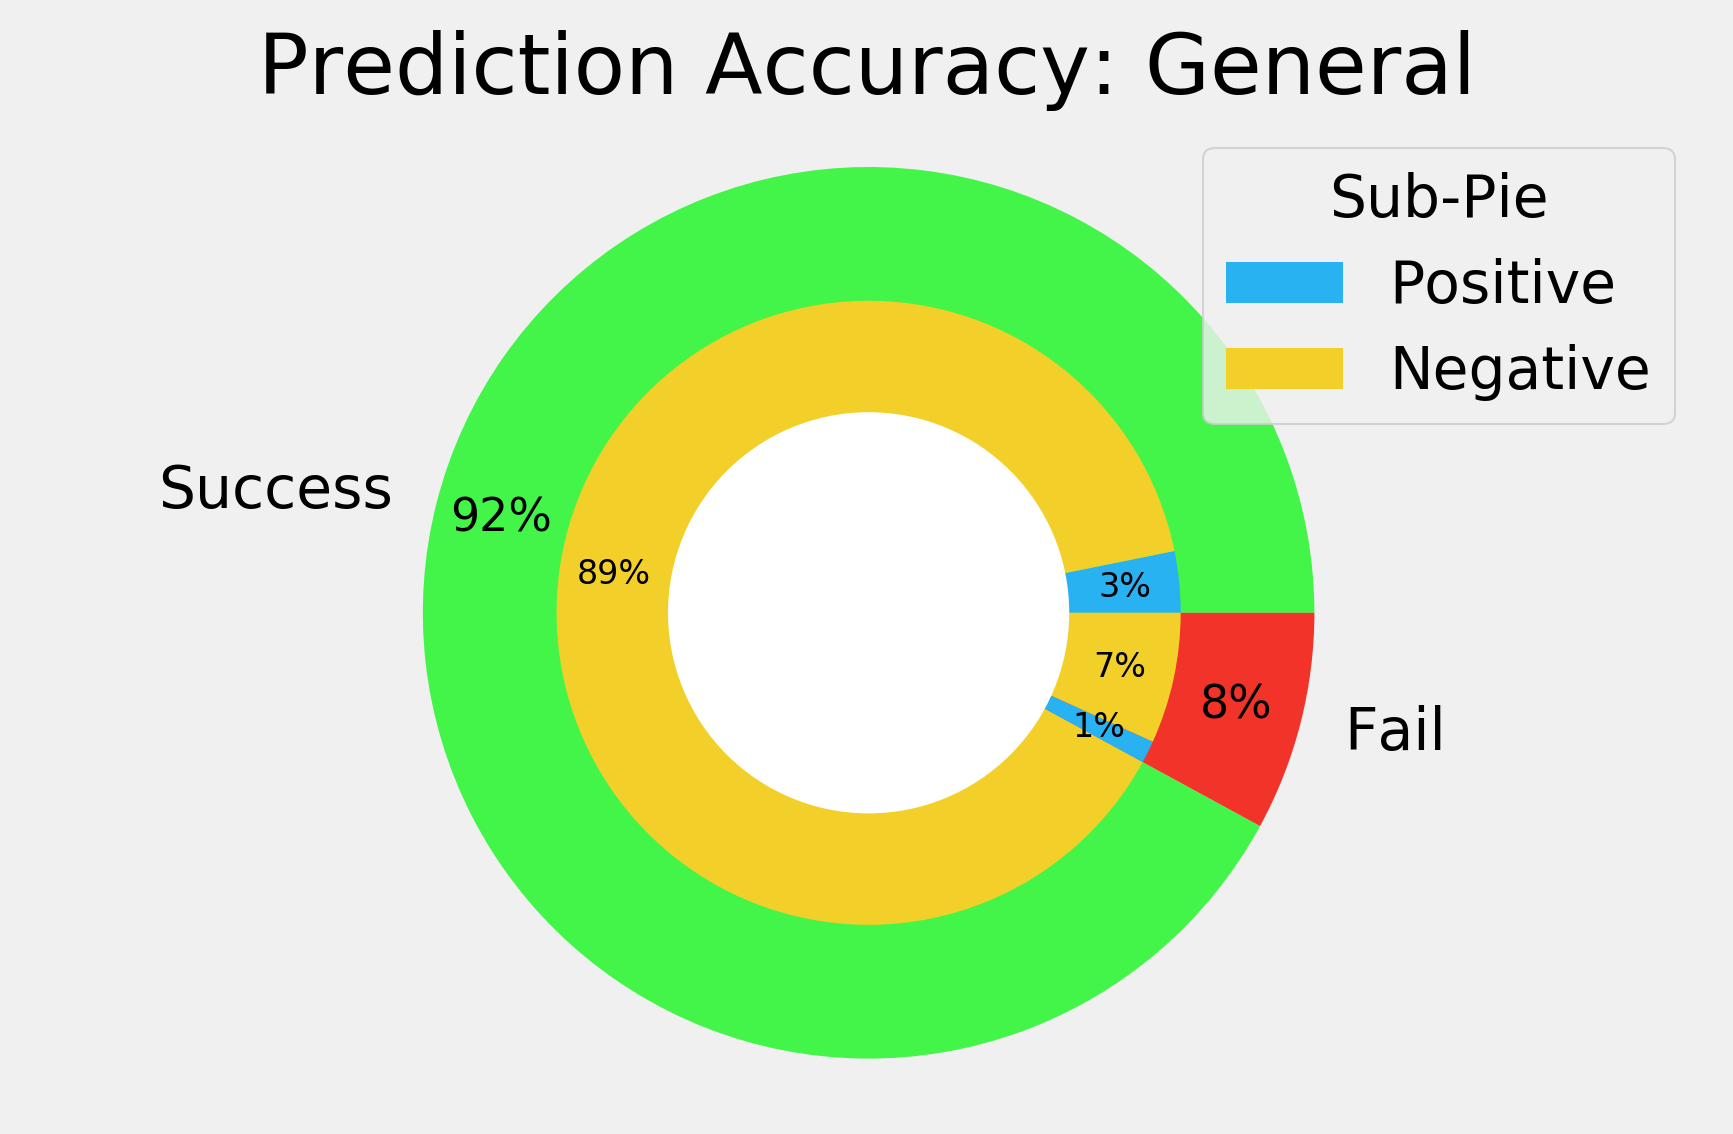

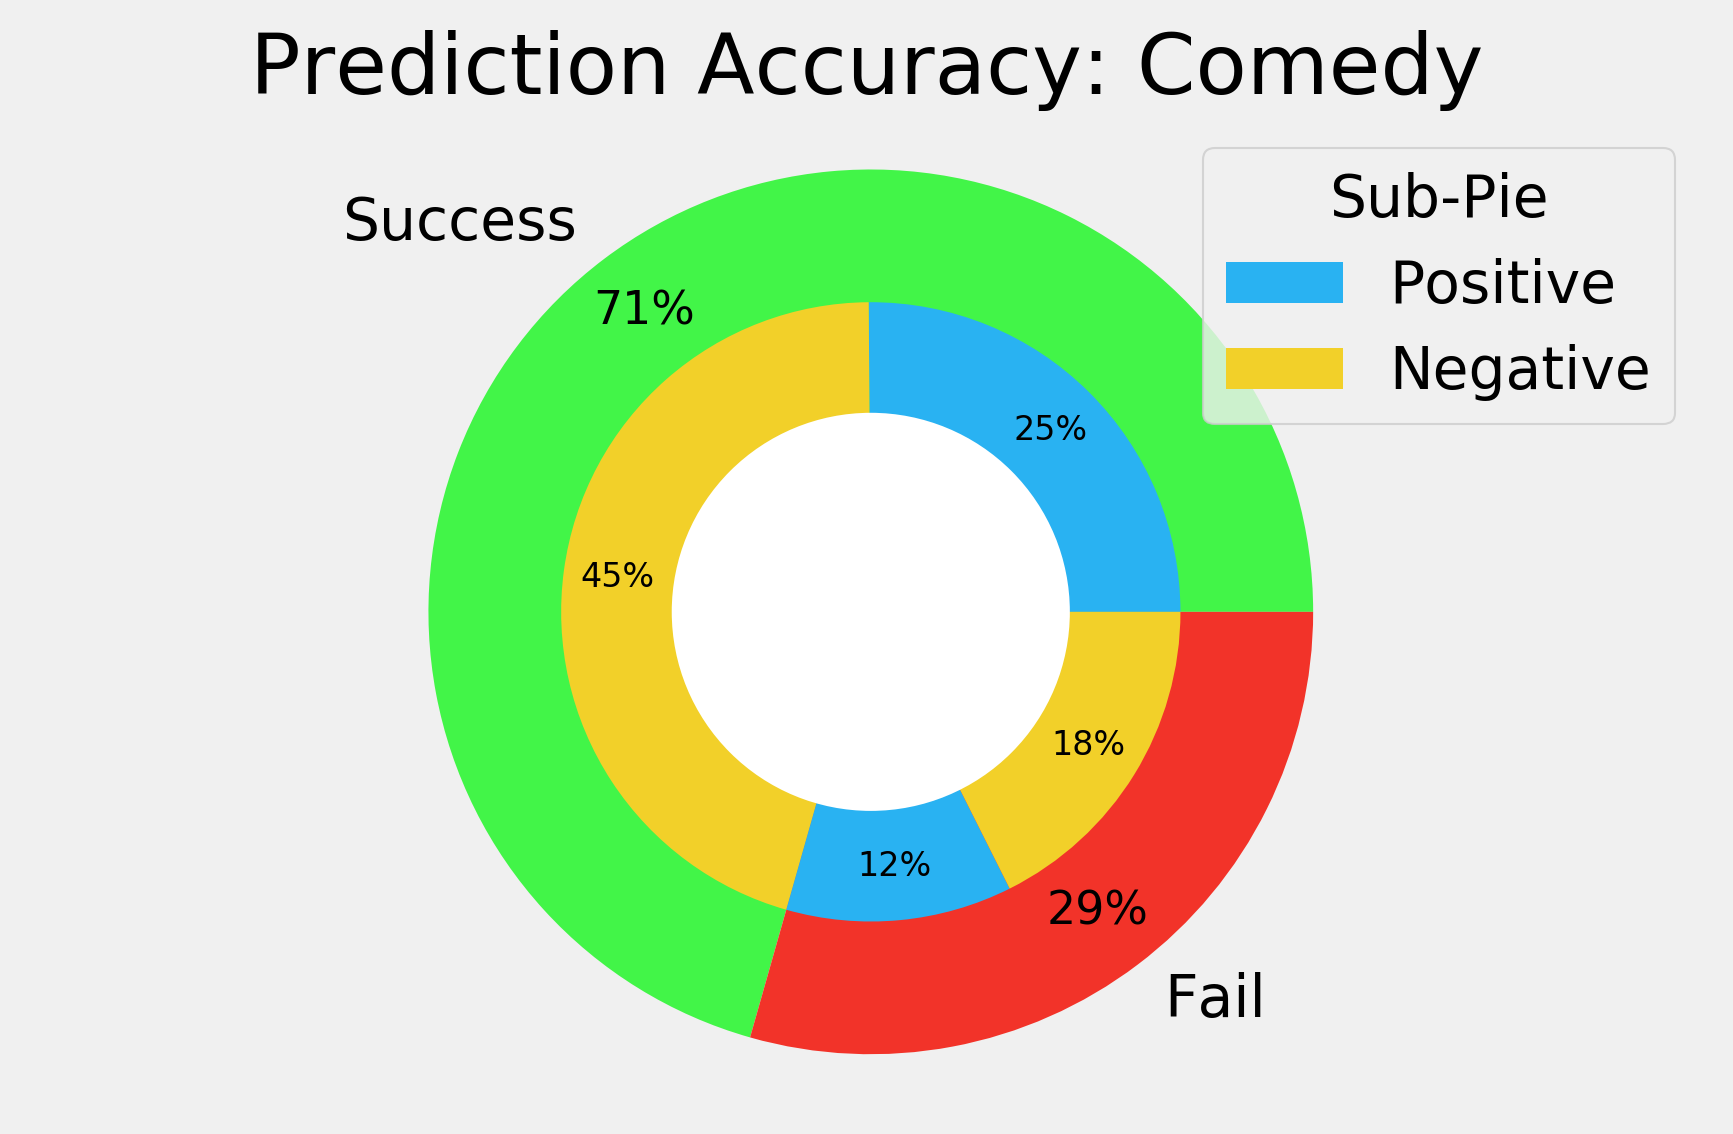

In [374]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI
style.use("fivethirtyeight")

def accuracy_pie(line_as_series, title="General Prediction Accuracy"):
    # accuracy = overall_accuracy
    # sub_accuracies = ["True Positive", "True Negative", "False Positive", "False Negative"]
    
    color_h = {"green": "#42f548", "red": "#f23329", "cyan": "#29b2f2", "yellow": "#f2d029"}

    # Data to plot
    labels = ["Success", "Fail"]
    labels_subpie = ["True Positive", "True Negative", "False Positive", "False Negative"]
    sizes = [line_as_series.accuracy, 100 - line_as_series.accuracy]
    sizes_subpie = [line_as_series.true_positive, line_as_series.true_negative,
                    line_as_series.false_positive, line_as_series.false_negative]
    colors = [color_h["green"], color_h["red"]]
    colors_subpie = [color_h["cyan"], color_h["yellow"], color_h["cyan"], color_h["yellow"]]
    # If the name attribute is empty, it means that the plot is on general accuracy. Otherwise it's on a particual genre
    accuracy_type = line_as_series.name if line_as_series.name != None else "General" 
    title = "Prediction Accuracy: " + accuracy_type

    # Plot
    wedges, labels, autopct = plt.pie(sizes, labels=labels, colors=colors, startangle=0,frame=True,
                                      autopct='%1.0f%%', pctdistance=0.85)
    plt.setp(autopct, fontsize=11)
    
    wedges, labels, autopct = plt.pie(sizes_subpie, colors=colors_subpie,radius=0.7,startangle=0,
                                      autopct='%1.0f%%', pctdistance=0.825, labeldistance = .4)
    plt.setp(labels, fontsize=6)
    plt.setp(autopct, fontsize=8)
    plt.legend(wedges[:2], ["Positive", "Negative"], title = "Sub-Pie")
    
    centre_circle = plt.Circle((0,0),0.45,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()    
    
accuracy_pie(m)
accuracy_pie(accuracy_df.loc["Comedy"])

In [371]:
accuracy_df.mean().name == None

True

In [246]:
a = 5
a
b = 6
b


5

6